In [1]:
import sys
sys.path.append("../../")

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.test_functions.multi_objective import GMM, BraninCurrin


tkwargs = {"dtype": torch.double, "device": torch.device("cpu"),}

In [3]:
# define problem
problem = GMM(negate=True).to(**tkwargs)
problem.ref_point = torch.tensor([0., 0.], **tkwargs)
# problem = BraninCurrin(negate=True).to(**tkwargs)

In [4]:
def plot_objective(problem, num_samples: int = 200):
    num_dim = problem.bounds.shape[-1]
    num_obj = problem.ref_point.shape[-1]

    fig = plt.figure(figsize=(5 * (num_dim + 1), 5))

    # only plot the first two dimensions
    xx, yy = np.meshgrid(
        np.linspace(
            *problem.bounds.cpu().t()[0], num_samples
        ),
        np.linspace(
            *problem.bounds.cpu().t()[1], num_samples
        ),
    )
    input_data = np.vstack((xx.flatten(), yy.flatten())).T
    input_data = torch.from_numpy(input_data)
    z = problem(input_data.to(**tkwargs)).cpu()
    pareto = is_non_dominated(z).cpu()
    pareto_set = z.cpu().numpy().copy()
    pareto_set[~pareto] = np.nan

    for i in range(num_dim):
        ax = plt.subplot2grid((1, num_dim + 1), (0, i))
        div = make_axes_locatable(ax)
        cax = div.append_axes('right', '5%', '5%')

        # plot functions
        countourset = ax.contourf(
            xx,
            yy,
            z[:, i].reshape(xx.shape),
        )

        # plot pareto set mask
        ax.scatter(*input_data[pareto].t(), color='tab:red', s=10, label='pareto set')

        cax.grid(False)  # just to remove the warning
        clb = fig.colorbar(countourset, cax=cax)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(f"objective {i+1}")
        ax.legend()
        clb.ax.set_title('z')

    ax_pareto = plt.subplot2grid((1, num_dim + 1), (0, num_dim))
    idx = np.argsort(pareto_set[:, 0])
    ax_pareto.plot(*pareto_set[idx].T, color='tab:red', label='approximated pareto front')
    ax_pareto.scatter(*pareto_set[idx].T, color='tab:red', s=10)
    ax_pareto.scatter(*problem.ref_point.cpu().t(), color='tab:red', marker='x', label='refence point')
    ax_pareto.set_title("pareto front")
    ax_pareto.legend()
    plt.tight_layout()

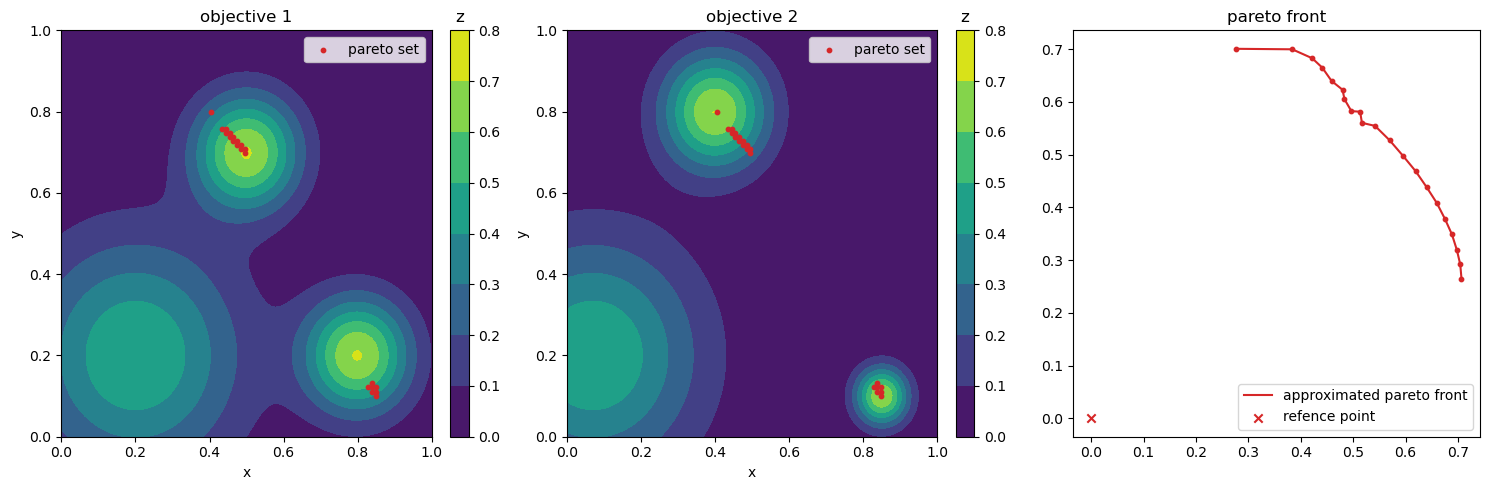

In [5]:
plot_objective(problem, num_samples=100)

In [6]:
def generate_initial_data(problem, n=6):
    # generate training data
    train_x = draw_sobol_samples(bounds=problem.bounds, n=n, q=1).squeeze(1)
    train_obj = problem(train_x)
    return train_x, train_obj

In [7]:
init_x, init_y = generate_initial_data(problem, n=6)

## Generate data

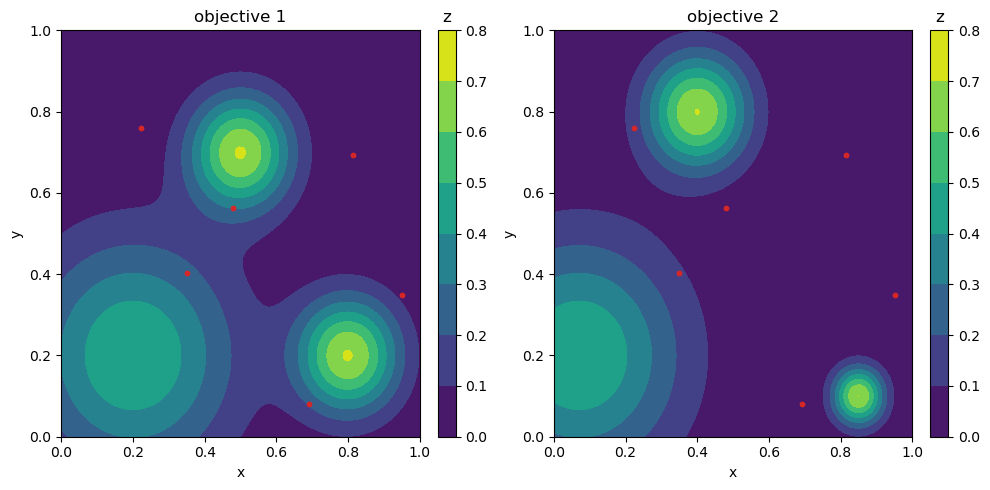

In [8]:
num_dim = problem.bounds.shape[-1]
# only plot the first two dimensions
xx, yy = np.meshgrid(
    np.linspace(
        *problem.bounds.cpu().t()[0], 200
    ),
    np.linspace(
        *problem.bounds.cpu().t()[1], 200
    ),
)
input_data = np.vstack((xx.flatten(), yy.flatten())).T
input_data = torch.from_numpy(input_data).to(**tkwargs)
z = problem(input_data.to(**tkwargs))

fig = plt.figure(figsize=(5 * (num_dim), 5))
for i in range(num_dim):
    ax = plt.subplot2grid((1, num_dim), (0, i))
    div = make_axes_locatable(ax)
    cax = div.append_axes('right', '5%', '5%')

    # plot functions
    countourset = ax.contourf(
        xx,
        yy,
        z[:, i].cpu().reshape(xx.shape),
    )

    # plot observations
    ax.scatter(*init_x.cpu().t(), s=10, color='tab:red')

    cax.grid(False)  # just to remove the warning
    clb = fig.colorbar(countourset, cax=cax)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f"objective {i+1}")
    clb.ax.set_title('z')
plt.tight_layout()

In [9]:
import math

class JointMLP(torch.nn.Module):

    def __init__(
        self,
        input_dim,
        output_dim,
        device="cpu:0",
        dtype=torch.double,
    ) -> None:
        super().__init__()
        self.tkwargs = {"device": device, "dtype": dtype}
        # define shared features
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, output_dim)
        )

    def forward(self, x, gamma):
        input = torch.concat([x, gamma], dim=-1)
        logits = self.layers(input)
        return logits


class LFBO_JointRand:

    def __init__(
        self,
        input_dim,
        output_dim,
        weight_type='ei',
        interpolation='lower',
        device="cpu:0",
        dtype=torch.double,
    ):
        self.tkwargs = {"device": device, "dtype": dtype}
        self.clf = JointMLP(
            input_dim=input_dim + 1, # plus 1 for gamma
            output_dim=output_dim,
            device=device,
            dtype=dtype,
        )
        self.clf.to(**self.tkwargs)
        self.weight_type = weight_type
        self.interpolation = interpolation

    @staticmethod
    def split_good_bad(X, y, gamma, interpolation):
        tau = torch.quantile(torch.unique(y), q=gamma, interpolation=interpolation)
        z = torch.less(y, tau)

        z_idx = z.squeeze()

        x1, z1 = X[z_idx], z[z_idx]
        x0, z0 = X, torch.zeros_like(z)

        w1 = (tau - y)[z_idx]
        # sometimes w1 is empty
        w1 = w1 / torch.mean(w1) if len(w1) else w1
        w0 = 1 - z0.int()

        x = torch.concat([x1, x0], axis=0)
        z = torch.concat([z1, z0], axis=0)
        s1 = x1.shape[0]
        s0 = x0.shape[0]

        w = torch.concat([w1 * (s1 + s0) / s1, w0 * (s1 + s0) / s0], axis=0)
        w = w / torch.mean(w)

        return x, y, z, w 

    def fit(self, X_obs, y_obs, batch_size=64, S=1000):
        optimizer = torch.optim.AdamW(self.clf.parameters())
        loss_fn = torch.nn.functional.binary_cross_entropy_with_logits

        N = len(X_obs)  # N-th iteration
        M = math.ceil(N / batch_size)  # Steps per epochs
        E = math.floor(S / M)

        self.clf.train()
        for _ in range(E):
            gamma = torch.rand(1, **self.tkwargs)
            new_X, _, new_z, new_w = self.split_good_bad(
                X_obs.detach(), y_obs.detach(), gamma=gamma, interpolation=self.interpolation
            )
            new_quantile = torch.tensor([[gamma]] * len(new_X), **self.tkwargs)

            # add batch dimension
            train_tensors = [new_X.unsqueeze(1), new_z.to(**self.tkwargs), new_w, new_quantile.unsqueeze(1)]
            train_dataset = torch.utils.data.TensorDataset(*train_tensors)
            train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

            for _, (inputs, targets, weights, quantile) in enumerate(train_dataloader):
                optimizer.zero_grad()

                outputs = self.clf(inputs, quantile)
                batch_loss = loss_fn(outputs.squeeze(1), targets, weight=weights)
                batch_loss.backward()
                optimizer.step()

        self.clf.eval()

    def predict(self, X, gamma):
        quantile = torch.tensor([gamma] * X.shape[0], **self.tkwargs)
        # add batch dimension
        if len(quantile.shape) == 1:
            quantile = quantile[..., None, None]

        with torch.no_grad():
            return torch.sigmoid(self.clf(X.unsqueeze(1), quantile)).squeeze(-2)

In [10]:
# To polar coordinates
def cart2pol(x, y):
    rho = torch.sqrt(x**2 + y**2)
    phi = torch.arctan2(y, x)
    return (rho.reshape(-1, 1), phi.reshape(-1, 1))

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return (x, y)

In [11]:
rhos, phis = cart2pol(init_y[:, 0], init_y[:, 1])

In [12]:
rhos

tensor([[0.2132],
        [0.1422],
        [0.2553],
        [0.0052],
        [0.0745],
        [0.3043]], dtype=torch.float64)

In [13]:
phis

tensor([[3.5997e-02],
        [1.4124e+00],
        [4.5852e-01],
        [1.8770e-02],
        [3.1997e-04],
        [1.3900e-01]], dtype=torch.float64)

In [ ]:
optimizer = LFBO_JointRand(input_dim=2, output_dim=1).fit(init_x, rhos)